# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [11]:
# Enrichment Constants
assays = {'LWR': 0.043, 'MMR':0.13, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']
adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

#Plotting orders
plotting_order_nogrowth = ['s5', 's2', 's7', 's6','s3', 's4']
plotting_order_1percent = ['s11', 's08', 's13', 's12','s09','s10']
colors = {'s2':'tab:orange', 's3':'tab:purple','s4':'tab:brown',
                   's5':'tab:blue', 's6':'tab:red', 's7':'tab:green',
                   's08':'tab:orange', 's09':'tab:purple','s10':'tab:brown',
                   's11':'tab:blue', 's12':'tab:red', 's13':'tab:green'}
lines = {'s2':'-', 's3':':','s4':'-.','s5':(0,(5,5)), 's6':(0,(5,1)), 's7':(0, (3,1,1,1)),
                's08':'-', 's09':':','s10':'-.','s11':(0,(5,5)), 's12':(0,(5,1)), 's13':(0, (3,1,1,1))}
labels = {'s2':'Scenario 2', 's3':'Scenario 3', 's4':'Scenario 4', 's5':'Scenario 5',
         's6':'Scenario 6', 's7':'Scenario 7', 's08':'Scenario 8', 's09':'Scenario 9',
         's10':'Scenario 10', 's11':'Scenario 11', 's12':'Scenario 12', 's13':'Scenario 13'}

# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.8857, 'Xe-100':0.895285, 'VOYGR':0.881427}

#Waste commodity names for each type of reactor
waste_commodity = {'LWR':'spent_uox', 'MMR':'spent_MMR_haleu',
                   'Xe-100':'spent_xe100_haleu', 'VOYGR':'spent_smr_fuel'}

#Time period
time = np.linspace(2025, 2089, 65)

## Scenario 1

In [18]:
s1_outfile = "../outputs/united_states_2020.sqlite"

In [ ]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

In [31]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [32]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1091])
print(s1_reactors[['lwr_total','Year']][30:35])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
Prototype  lwr_total     Year
30               0.0  1967.50
31               0.0  1967.58
32               2.0  1967.67
33               2.0  1967.75
34               2.0  1967.83


In [33]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

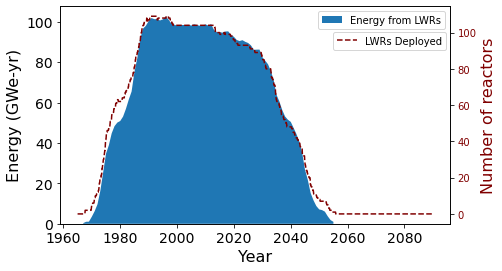

In [35]:
#combine energy and reactors for scenario 1 into a single plot
fig = plt.figure(figsize=(7,4))
ax1 = fig.add_subplot(111)
ax1.stackplot(s1_energy['Year'], s1_energy['Energy'], labels=['Energy from LWRs'])
ax1.legend()
ax1.set_ylabel('Energy (GWe-yr)', fontsize=16)

ax2 = ax1.twinx()
ax2.plot(s1_reactors['Year'], s1_reactors['lwr_total'], 'maroon', 
         linestyle='--', label='LWRs Deployed')
ax2.legend(loc=(0.7, 0.8))
ax2.set_ylabel('Number of reactors', color='maroon', fontsize=16)
ax2.tick_params(axis='y', labelcolor='maroon')

ax1.set_xlabel('Year', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
plt.savefig('figures/s1_energy_reactors.pdf', bbox_inches='tight')

In [36]:
s1_transactions = tm.add_receiver_prototype(s1_outfile)

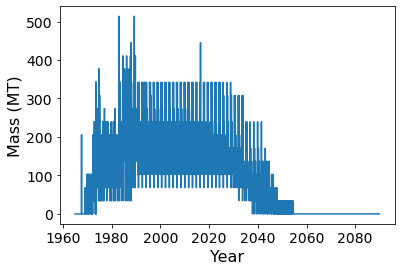

In [150]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf', bbox_inches='tight')

In [149]:
print('Max uranium:',s1_uox['Quantity'].max()/1000)
print('Average across entire time:',s1_uox['Quantity'][32:1089].mean()/1000)
print('Average after 2025:',s1_uox['Quantity'][721:1089].mean()/1000)
print('Average before 2025:',s1_uox['Quantity'][32:721].mean()/1000)
print('Total after 2025:', s1_uox['Quantity'][721:].cumsum()[1499]/1000)

Max uranium: 513.7178423236442
Average across entire time: 135.74253053148882
Average after 2025: 81.11040952552757
Average before 2025: 164.92195074947685
Total after 2025: 29848.63070539421


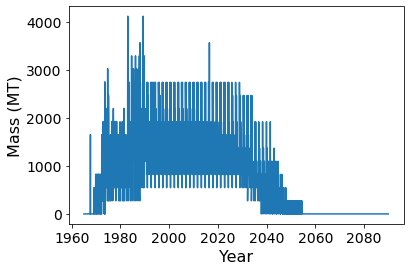

In [151]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf', bbox_inches='tight')

In [148]:
print('Maximum needed:',s1_feed.max()/1000)
print('Average feed:',s1_feed[32:1089].mean()/1000)
print('Average feed after 2025:', s1_feed[721:1089].mean()/1000)
print('Average feed before 2025:', s1_feed[32:721].mean()/1000)

Maximum needed: 4121.806562675031
Average feed: 1089.1279357712408
Average feed after 2025: 650.7880216333915
Average feed before 2025: 1323.2485285183072


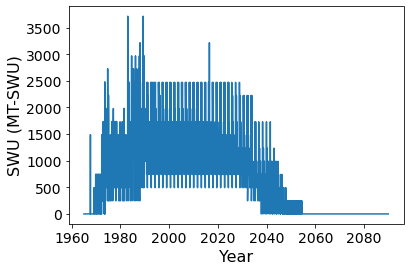

In [152]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU (MT-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf', bbox_inches='tight')

In [147]:
print('Maximum needed:',s1_swu.max()/1000)
print('Average SWU:',s1_swu[32:1089].mean()/1000)
print('Average SWU after 2025:', s1_swu[721:1089].mean()/1000)
print('Average SWU before 2025:', s1_swu[32:721].mean()/1000)

Maximum needed: 3714.1664210974054
Average SWU: 981.4149077135144
Average SWU after 2025: 586.4261169098742
Average SWU before 2025: 1192.3813446013803


Cumulative: 137581.92946057965


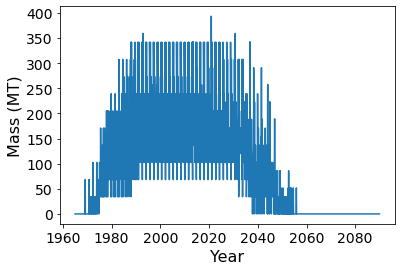

In [153]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (MT)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf', bbox_inches='tight')
print('Cumulative:', s1_waste['Quantity'].cumsum()[1499]/1000)

In [44]:
print('Maximum needed:',s1_waste['Quantity'].max())
print('Average waste:',s1_waste['Quantity'][32:1089].mean())
print('Average waste after 2025:', s1_waste['Quantity'][721:1089].mean())
print('Average waste before 2025:', s1_waste['Quantity'][32:721].mean())

Maximum needed: 393622.40663899935
Average waste: 130113.73298735515
Average waste after 2025: 93898.30642251472
Average waste before 2025: 149456.66038338022


## No growth scenarios

In [12]:
out_files_nogrowth = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

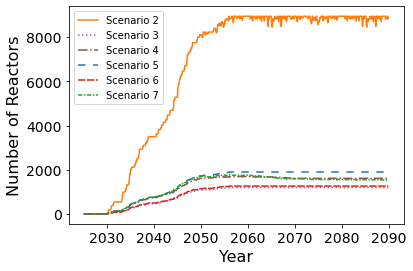

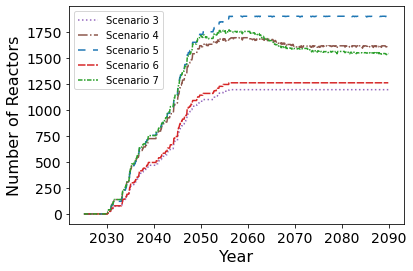

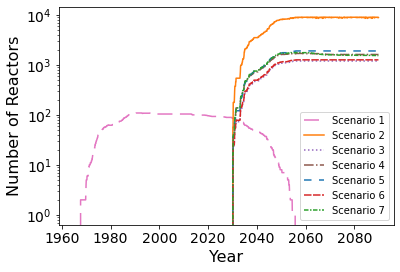

In [20]:
reactors_nogrowth = {'s2_reactors':'',
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
plt.figure(0)
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s3_reactors','s4_reactors','s5_reactors','s6_reactors','s7_reactors']:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'][721:], reactors_nogrowth[key]['advrx_total'][721:], 
            label=labels[scenario],
            color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_reactors_3-7.pdf', bbox_inches='tight')

plt.figure(2)
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'], label='Scenario 1', color='tab:pink', 
        linestyle=(0,(10,5)))
for key in reactors_nogrowth:
    scenario = key[:2]
    reactors_nogrowth[key] = tm.get_prototype_totals(out_files_nogrowth[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_nogrowth[key]['Year'], reactors_nogrowth[key]['advrx_total'], 
             label=labels[scenario],
            color = colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.yscale('log')
plt.savefig('figures/reactors_1-7.pdf', bbox_inches='tight')

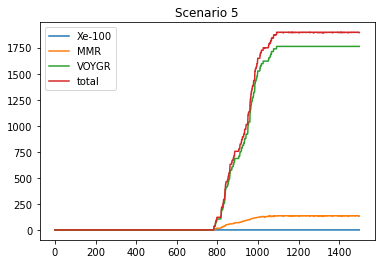

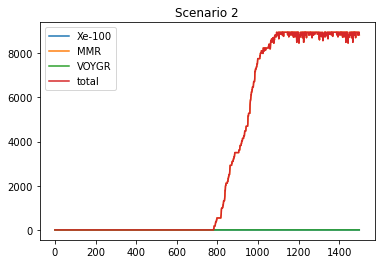

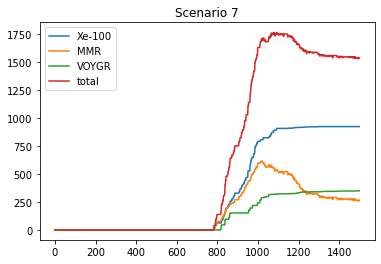

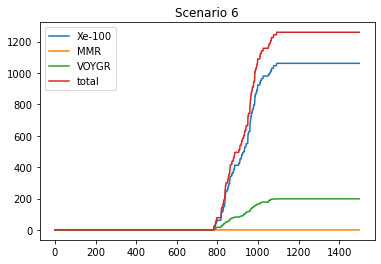

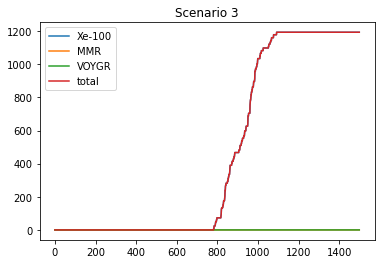

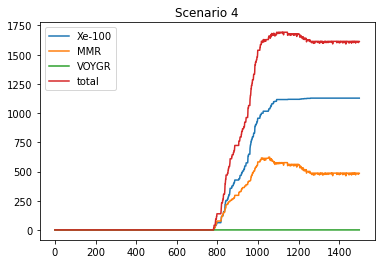

In [106]:
for scenario in plotting_order_nogrowth:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_nogrowth[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_nogrowth[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [30]:
for key in reactors_nogrowth:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_nogrowth[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_nogrowth[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_nogrowth[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_nogrowth[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_nogrowth[key]['advrx_enter'].max())
    advrx_sum = reactors_nogrowth[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 8946.0
Max MMR added in one step in S2: 378.0
Total number of MMR deployed in S2: 25887.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2: 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2: 0.0
Max Adv Rx in S2: 8946.0
Max Adv Rx added in one step in S2: 378.0
Total number of reactors deployed in S2: 25887.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3: 0.0
Max Xe-100 in S3: 1193.0
Max Xe-100 added in one step in S3: 50.0
Total number of Xe-100 deployed in S3: 1193.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3: 0.0
Max Adv Rx in S3: 1193.0
Max Adv Rx added in one step in S3: 50.0
Total number of reactors deployed in S3: 1193.0
Max MMR in S4: 623.0
Max MMR added in one step in S4: 26.0
Total number of MMR deployed in S4: 1587.0
Max Xe-100 in S4: 1128.0
Max Xe-100 added in o

In [118]:
# Energy
energy_nogrowth = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy_nogrowth:
    scenario = key[:2]
    energy_nogrowth[key] = tm.get_annual_electricity(out_files_nogrowth[scenario + '_outfile'])

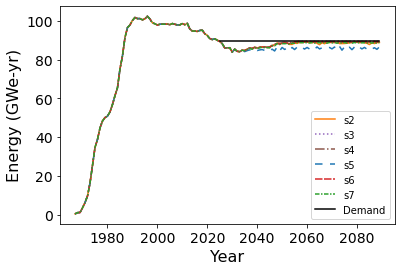

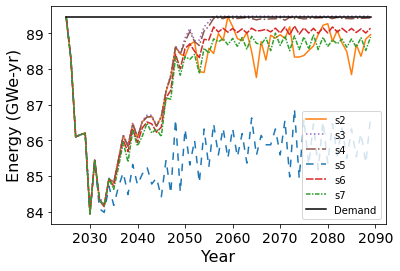

In [32]:
for key in energy_nogrowth:
    scenario = key[:2]
    
    plt.figure(0)
    plt.plot(energy_nogrowth[key]['Year'], energy_nogrowth[key]['Energy'], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
    
    plt.figure(1)
    plt.plot(energy_nogrowth[key]['Year'][58:], energy_nogrowth[key]['Energy'][58:], label=scenario,
            color=colors[scenario], linestyle=lines[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig('figures/nogrowth_energy_after_2025.pdf', bbox_inches='tight')

In [13]:
# Fuel mass
transactions_nogrowth = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel_nogrowth = {'s2':'', 's3':'', 's4':'',
             's5':'', 's6':'', 's7':''}
for key in total_fuel_nogrowth:
    scenario = key[:2]
    transactions_nogrowth[scenario] = tm.add_receiver_prototype(out_files_nogrowth[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_nogrowth[scenario], 'fresh_uox')
    total_fuel_nogrowth[key] = tm.add_year(fuel)

In [49]:
#Dividing fuel mass by prototype
uranium_to_reactors_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in uranium_to_reactors_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_LWR(transactions_nogrowth[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_nogrowth[key] = tm.commodity_to_prototype(transactions_nogrowth[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_nogrowth[key]['Quantity'] = uranium_to_reactors_nogrowth[key]['Quantity']*uranium_fractions[reactor]

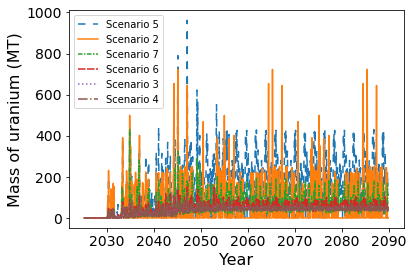

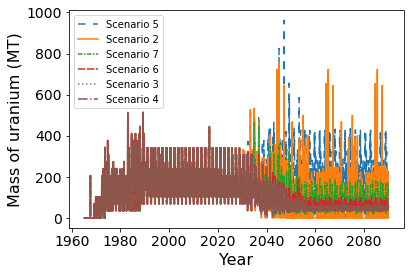

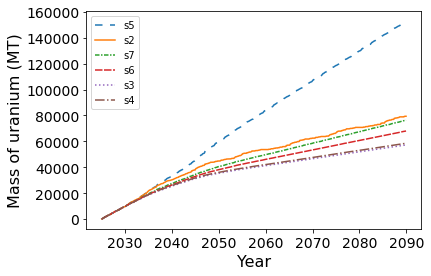

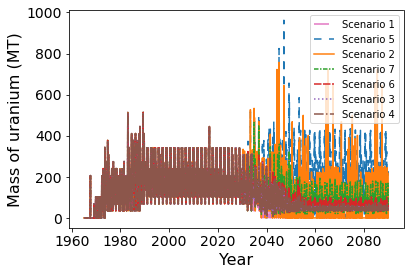

In [154]:
plt.figure(4)
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000, label='Scenario 1',
        color='tab:pink', linestyle=(0,(10,5)))
for key in plotting_order_nogrowth:
      
    plt.figure(1)
    AR_uranium = uranium_to_reactors_nogrowth[key + '_MMR'].copy()

    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_nogrowth[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium[721:]['Quantity']/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_uranium.pdf', bbox_inches='tight')
    
    plt.figure(2)
    uranium_to_reactors_nogrowth[key + '_total'] = AR_uranium['Quantity'] 
    uranium_to_reactors_nogrowth[key + '_total'] += uranium_to_reactors_nogrowth[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_uranium.pdf', bbox_inches='tight')
    
    plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], 
            uranium_to_reactors_nogrowth[key+'_total'][721:].cumsum()/1000, label=key,
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_uranium_cumulative.pdf', bbox_inches='tight')
    
    plt.figure(4)
    plt.plot(AR_uranium['Year'], AR_uranium['Quantity']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/uranium_1-7.pdf', bbox_inches='tight')

In [9]:
#Reporting uranium masses
for scenario in plotting_order_nogrowth:
    HALEU_mass = uranium_to_reactors_nogrowth[scenario+'_MMR'] + uranium_to_reactors_nogrowth[scenario+'_Xe-100']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:]['Quantity'].mean())
    AR_mass = HALEU_mass + uranium_to_reactors_nogrowth[scenario+'_VOYGR']
    print('Non-HALEU max:', uranium_to_reactors_nogrowth[scenario+'_VOYGR'][721:]['Quantity'].max())
    print('Average mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].mean())
    print('Maximum mass in', scenario, 'after 2025:', 
          AR_mass[721:]['Quantity'].max())

Average HALEU mass in s5 after 2025: 974.8575636020539
Non-HALEU max: 958453.3718470247
Average mass in s5 after 2025: 157753.8730045168
Maximum mass in s5 after 2025: 962279.1352830246
Average HALEU mass in s2 after 2025: 63567.09760444918
Non-HALEU max: 0.0
Average mass in s2 after 2025: 63567.09760444918
Maximum mass in s2 after 2025: 723069.2894039975
Average HALEU mass in s7 after 2025: 29792.901784433347
Non-HALEU max: 407274.8039009995
Average mass in s7 after 2025: 59687.60433521535
Maximum mass in s7 after 2025: 430825.5216121395
Average HALEU mass in s6 after 2025: 31219.7223071255
Non-HALEU max: 103176.28365491996
Average mass in s6 after 2025: 48939.74886281813
Maximum mass in s6 after 2025: 151098.00216419986
Average HALEU mass in s3 after 2025: 35132.35653503663
Non-HALEU max: 0.0
Average mass in s3 after 2025: 35132.35653503663
Maximum mass in s3 after 2025: 97186.6031575598
Average HALEU mass in s4 after 2025: 36810.99324214473
Non-HALEU max: 0.0
Average mass in s4 afte

In [61]:
#SWU Calculations
tails_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
SWU_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
        's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
        's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
        's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
        's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
        's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':'',}
for key in feed_nogrowth:
    reactor = key[3:]
    if reactor != 'total':
        tails_nogrowth[key] = tm.calculate_tails(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_nogrowth[key] = tm.calculate_feed(uranium_to_reactors_nogrowth[key]['Quantity'], 
                                           tails_nogrowth[key])
        SWU_nogrowth[key] = tm.calculate_SWU(uranium_to_reactors_nogrowth[key]['Quantity'],
                                assays[reactor], tails_nogrowth[key], assays['tails'],
                                feed_nogrowth[key], assays['feed'])

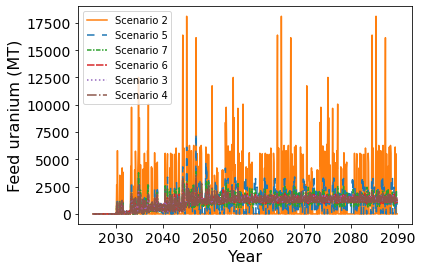

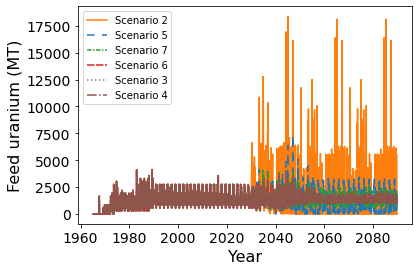

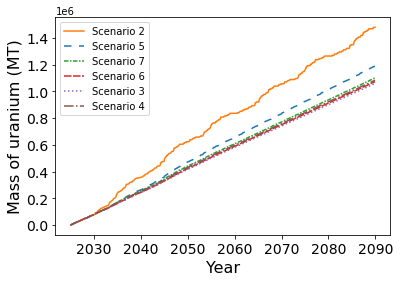

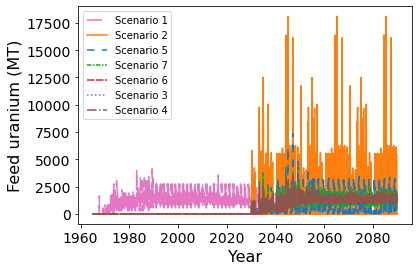

In [155]:
plt.figure(3)
plt.plot(s1_uox['Year'], s1_feed/1000, label='Scenario 1', color='tab:pink',
        linestyle=(0,(10,5)))
for key in ['s2','s5','s7','s6','s3','s4']:
    AR_feed = feed_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_feed.pdf', bbox_inches='tight')
    
    plt.figure(1)
    feed_nogrowth[key+'_total'] = AR_feed + feed_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], feed_nogrowth[key+'_total']/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_feed.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key+'_MMR']['Year'][721:], feed_nogrowth[key+'_total'][721:].cumsum()/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_feed_cumulative.pdf', bbox_inches='tight')
    
    plt.figure(3)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_feed/1000, 
             label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/feed_1-7.pdf', bbox_inches='tight')

In [63]:
#Reporting feed masses
for scenario in plotting_order_nogrowth:
    HALEU_feed = feed_nogrowth[scenario+'_MMR'] + feed_nogrowth[scenario+'_Xe-100']
    print('Average feed for HALEU in',scenario, 'after 2025:', HALEU_feed[721:].mean())
    AR_feed = HALEU_feed + feed_nogrowth[scenario+'_VOYGR']
    print('AR Average mass in', scenario, 'after 2025:', AR_feed[721:].mean())
    print('AR Maximum mass in', scenario, 'after 2025:', AR_feed[721:].max())

Average feed for HALEU in s5 after 2025: 24419.132708622878
AR Average mass in s5 after 2025: 1217903.2228557037
AR Maximum mass in s5 after 2025: 7392080.99504056
Average feed for HALEU in s2 after 2025: 1592287.3763932479
AR Average mass in s2 after 2025: 1592287.3763932479
AR Maximum mass in s2 after 2025: 18112107.44495336
Average feed for HALEU in s7 after 2025: 877537.6578283178
AR Average mass in s7 after 2025: 1105111.8122755624
AR Maximum mass in s7 after 2025: 3869351.1443781722
Average feed for HALEU in s6 after 2025: 934758.8088043446
AR Average mass in s6 after 2025: 1069652.9444240008
AR Maximum mass in s6 after 2025: 3190290.8505102377
Average feed for HALEU in s3 after 2025: 1051908.1310881812
AR Average mass in s3 after 2025: 1051908.1310881812
AR Maximum mass in s3 after 2025: 2909892.423308542
Average feed for HALEU in s4 after 2025: 1083103.248278528
AR Average mass in s4 after 2025: 1083103.248278528
AR Maximum mass in s4 after 2025: 3487825.5994382068


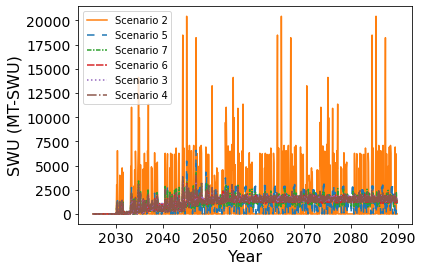

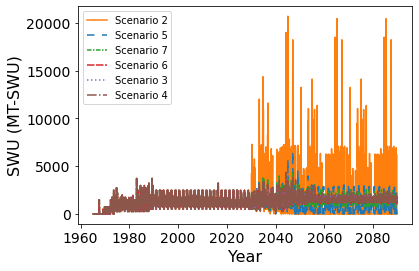

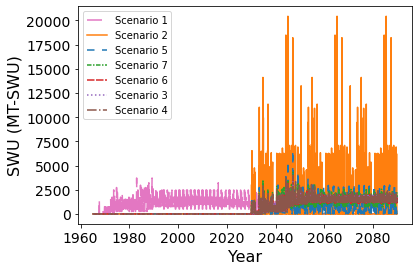

In [156]:
plt.figure(2)
plt.plot(s1_uox['Year'], s1_swu/1000, color='tab:pink', linestyle=(0,(10,5)),
        label='Scenario 1')
for key in ['s2', 's5', 's7', 's6','s3', 's4']:
    AR_SWU = SWU_nogrowth[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_nogrowth[key + '_' + reactor]
    plt.figure(0)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_AR_SWU.pdf', bbox_inches='tight')
    
    plt.figure(1)
    SWU_nogrowth[key+'_total'] = AR_SWU + SWU_nogrowth[key +'_LWR']
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], SWU_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/nogrowth_SWU.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_nogrowth[key + '_MMR']['Year'], AR_SWU/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/swu_1-7.pdf', bbox_inches='tight')

In [65]:
#Reporting SWU Requirements
for scenario in plotting_order_nogrowth:
    HALEU_SWU = SWU_nogrowth[scenario+'_MMR'] + SWU_nogrowth[scenario+'_Xe-100']
    print('Average HALEU SWU in', scenario, 'after 2025:', HALEU_SWU[721:].mean())
    AR_SWU = HALEU_SWU + SWU_nogrowth[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_SWU[721:].mean())
    print('Maximum mass in ', scenario, ':', AR_SWU[721:].max())

Average HALEU SWU in s5 after 2025: 27544.87832755822
Average mass in  s5 : 1085644.7549742518
Maximum mass in  s5 : 6576689.458946854
Average HALEU SWU in s2 after 2025: 1796106.4616259397
Average mass in  s2 : 1796106.4616259397
Maximum mass in  s2 : 20430528.871761754
Average HALEU SWU in s7 after 2025: 1008572.9695280979
Average mass in  s7 : 1210331.993160269
Maximum mass in  s7 : 4312164.60573883
Average HALEU SWU in s6 after 2025: 1076180.1344425525
Average mass in  s6 : 1195772.4016858728
Maximum mass in  s6 : 3552577.5619011065
Average HALEU SWU in s3 after 2025: 1211053.1864189594
Average mass in  s3 : 1211053.1864189594
Maximum mass in  s3 : 3350135.232568875
Average HALEU SWU in s4 after 2025: 1244694.6269795839
Average mass in  s4 : 1244694.6269795839
Maximum mass in  s4 : 3998767.1875528954


In [66]:
# Waste discharged from reactors
waste_nogrowth = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'', 's2_total':'',
                    's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'', 's3_total':'',
                    's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'', 's4_total':'',
                    's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'', 's5_total':'',
                    's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'', 's6_total':'',
                    's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'', 's7_total':''}
for key in waste_nogrowth:
    scenario = key[:2]
    reactor = key[3:]
    if reactor != 'total':
        waste_nogrowth[key] = tm.commodity_mass_traded(transactions_nogrowth[scenario], waste_commodity[reactor])

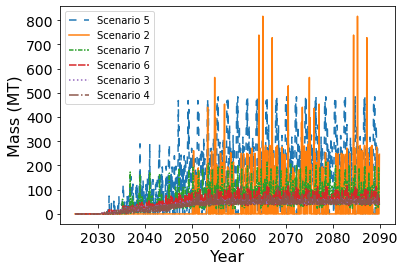

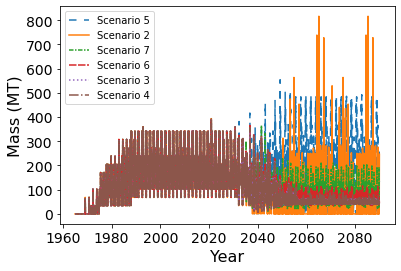

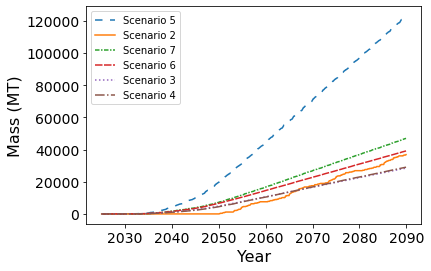

In [157]:
for key in plotting_order_nogrowth:
    AR_waste = waste_nogrowth[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_nogrowth[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key], 
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_AR_waste.pdf', bbox_inches='tight')
    
    plt.figure(1)
    waste_nogrowth[key+'_total'] = AR_waste['Quantity'] + waste_nogrowth[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_nogrowth[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_waste.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/nogrowth_waste_cumulative.pdf', bbox_inches='tight')

In [101]:
#Reporting waste masses
for scenario in plotting_order_nogrowth:
    HALEU_waste = waste_nogrowth[scenario+'_MMR']['Quantity'] + waste_nogrowth[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in', scenario, ': ', HALEU_waste[721:].mean())
    AR_waste = HALEU_waste + waste_nogrowth[scenario+'_VOYGR']['Quantity']
    print('Average AR waste in', scenario, 'after 2025:', AR_waste[721:].mean())
    print('Maximum  in', scenario, ':', AR_waste[721:].max())

Average HALEU waste in s5 :  734.6997432605904
Average AR waste in s5 after 2025: 157701.67265725296
Maximum  in s5 : 492264.8999999993
Average HALEU waste in s2 :  47284.16649550698
Average AR waste in s2 after 2025: 47284.16649550698
Maximum  in s2 : 816381.7199999972
Average HALEU waste in s7 :  30501.920528883227
Average AR waste in s7 after 2025: 60266.13277535306
Maximum  in s7 : 214458.7480000003
Average HALEU waste in s6 :  32486.580323491744
Average AR waste in s6 after 2025: 50241.50432862652
Maximum  in s6 : 115885.30800000025
Average HALEU waste in s3 :  36560.165930680494
Average AR waste in s3 after 2025: 36560.165930680494
Maximum  in s3 : 61780.628000000375
Average HALEU waste in s4 :  37283.69993838265
Average AR waste in s4 after 2025: 37283.69993838265
Maximum  in s4 : 114432.13200000029


## 1% Growth Scenarios

In [107]:
out_files_1percent = {'s08_outfile':"../outputs/mmr_1percent.sqlite",
                    's09_outfile':"../outputs/xe100_1percent.sqlite",
            's10_outfile':"../outputs/xe100_mmr_1percent.sqlite",
            's11_outfile':"../outputs/mmr_voygr_1percent.sqlite",
            's12_outfile':"../outputs/xe100_voygr_1percent.sqlite",
            's13_outfile':"../outputs/xe100_mmr_voygr_1percent.sqlite"}

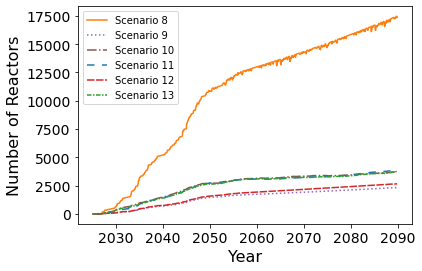

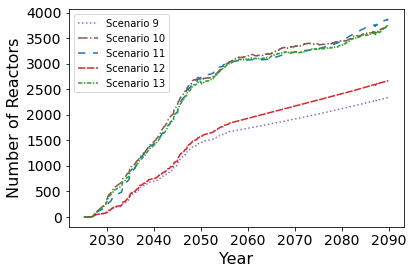

In [108]:
reactors_1percent = {'s08_reactors':"",'s09_reactors':"",
                    's10_reactors':"",'s11_reactors':"",
                    's12_reactors':"",'s13_reactors':""}
plt.figure(0)
for key in reactors_1percent:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors.pdf', bbox_inches='tight')

plt.figure(1)
for key in ['s09_reactors','s10_reactors','s11_reactors','s12_reactors','s13_reactors']:
    scenario = key[:3]
    reactors_1percent[key] = tm.get_prototype_totals(out_files_1percent[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors_1percent[key]['Year'][721:], reactors_1percent[key]['advrx_total'][721:], 
             label=labels[scenario], color=colors[scenario], linestyle=lines[scenario])
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Reactors', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_reactors_9-13.pdf', bbox_inches='tight')

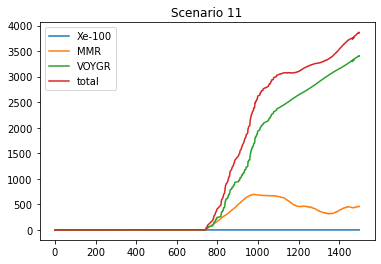

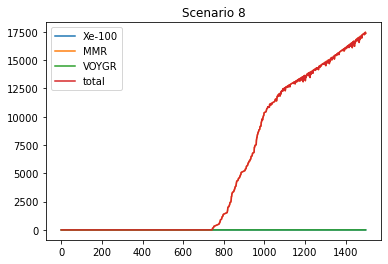

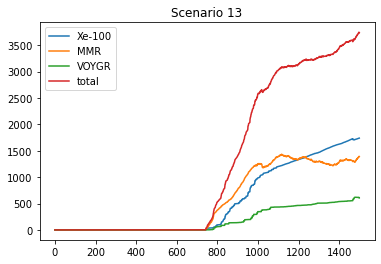

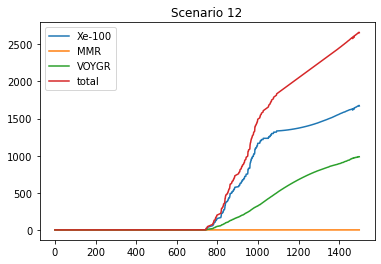

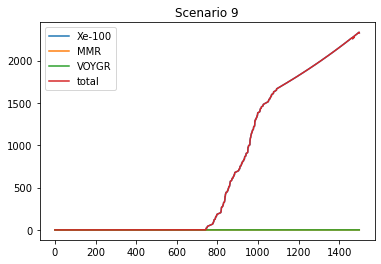

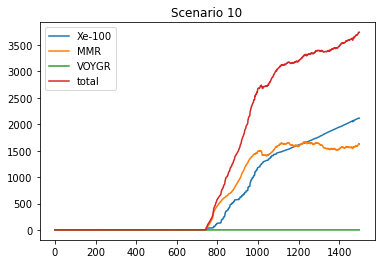

In [110]:
for scenario in plotting_order_1percent:
        plt.figure()
        for reactor in ['Xe-100', 'MMR', 'VOYGR']:
            num_rxs = reactors_1percent[scenario+'_reactors'][reactor+'_total']
            plt.plot(num_rxs, label = reactor)
        plt.plot(reactors_1percent[scenario+'_reactors']['advrx_total'], label='total')
        plt.legend()
        plt.title(labels[scenario])

In [82]:
for key in reactors_1percent:
    scenario = key[1:3]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors_1percent[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors_1percent[key][adv_rx +'_enter'].max())
        prototype_sum = reactors_1percent[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario}:', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors_1percent[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors_1percent[key]['advrx_enter'].max())
    advrx_sum = reactors_1percent[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S08: 17467.0
Max MMR added in one step in S08: 412.0
Total number of MMR deployed in S08; 43132.0
Max Xe-100 in S08: 0.0
Max Xe-100 added in one step in S08: 0.0
Total number of Xe-100 deployed in S08; 0.0
Max VOYGR in S08: 0.0
Max VOYGR added in one step in S08: 0.0
Total number of VOYGR deployed in S08; 0.0
Max Adv Rx in S08: 17467.0
Max Adv Rx added in one step in S08: 412.0
Total number of reactors deployed in S08: 43132.0
Max MMR in S09: 0.0
Max MMR added in one step in S09: 0.0
Total number of MMR deployed in S09; 0.0
Max Xe-100 in S09: 2335.0
Max Xe-100 added in one step in S09: 52.0
Total number of Xe-100 deployed in S09; 2407.0
Max VOYGR in S09: 0.0
Max VOYGR added in one step in S09: 0.0
Total number of VOYGR deployed in S09; 0.0
Max Adv Rx in S09: 2335.0
Max Adv Rx added in one step in S09: 52.0
Total number of reactors deployed in S09: 2407.0
Max MMR in S10: 1671.0
Max MMR added in one step in S10: 34.0
Total number of MMR deployed in S10; 4994.0
Max Xe-100 in S1

In [72]:
# Energy
energy_1percent = {'s08_energy':'', 's09_energy':'', 's10_energy':'',
                  's11_energy':'', 's12_energy':'', 's13_energy':''}
for key in energy_1percent:
    scenario = key[:3]
    energy_1percent[key] = tm.get_annual_electricity(out_files_1percent[scenario + '_outfile'])

In [158]:
demand = 89.45655* np.exp(0.01*(time-2025))

for key in energy_1percent:
    gap = demand-energy_1percent[key]['Energy'][58:]
    print(key, ':', gap.min(), gap.max())

s08_energy : -3.9416647444933517 2.90285885083604
s09_energy : -4.793288426926438 2.8653588508371683
s10_energy : -4.741946729745877 2.9045255175038136
s11_energy : 4.999999998744897e-05 3.0286237338190887
s12_energy : -2.9641217602604115 2.894525517503851
s13_energy : -3.655852002176715 2.904525517503785


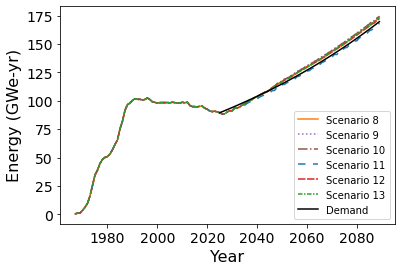

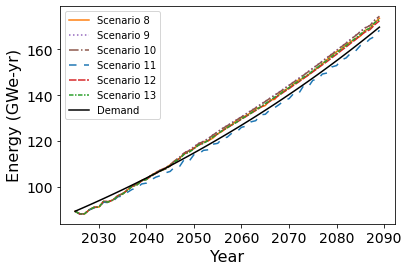

In [84]:
for key in energy_1percent:
    scenario = key[:3]
    plt.figure(0)
    plt.plot(energy_1percent[key]['Year'], energy_1percent[key]['Energy'], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
    
    plt.figure(1)
    plt.plot(energy_1percent[key]['Year'][58:], energy_1percent[key]['Energy'][58:], label=labels[scenario],
            linestyle=lines[scenario], color=colors[scenario])
plt.figure(0)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy.pdf', bbox_inches='tight')

plt.figure(1)
plt.plot(np.linspace(2025,2089,65), 89.45655* np.exp(0.01*(time-2025)), 'k', label='Demand')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Energy (GWe-yr)', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/1percent_energy_after_2025.pdf', bbox_inches='tight')

In [74]:
# Fuel mass
transactions_1percent = {'s08':'', 's09':'', 's10':'','s11':'', 's12':'','s13':''}
total_fuel_1percent = {'s08':'', 's09':'', 's10':'',
                       's11':'', 's12':'', 's13':''}

for key in total_fuel_1percent:
    scenario = key[:3]
    transactions_1percent[scenario] = tm.add_receiver_prototype(out_files_1percent[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions_1percent[scenario], 'fresh_uox')
    total_fuel_1percent[key] = tm.add_year(fuel)

In [75]:
#Dividing fuel mass by prototype
uranium_to_reactors_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in uranium_to_reactors_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor == 'LWR':
        uranium_to_reactors_1percent[key] = tm.commodity_to_LWR(transactions_1percent[scenario], 
                                                        'fresh_uox', adv_rxs)
    elif reactor != 'total': 
        uranium_to_reactors_1percent[key] = tm.commodity_to_prototype(transactions_1percent[scenario], 
                                                        'fresh_uox', reactor)
        uranium_to_reactors_1percent[key]['Quantity'] = uranium_to_reactors_1percent[key]['Quantity']*uranium_fractions[reactor]

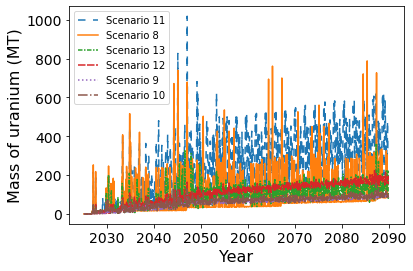

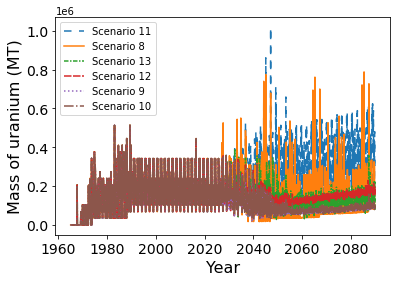

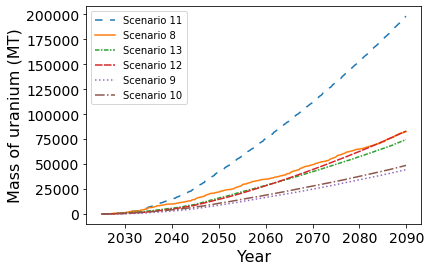

In [159]:
for key in plotting_order_1percent:

    plt.figure(1)
    AR_uranium = uranium_to_reactors_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += uranium_to_reactors_1percent[key+'_'+reactor]['Quantity']
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_uranium.pdf', bbox_inches='tight')

    plt.figure(2)
    uranium_to_reactors_1percent[key+'_total'] = AR_uranium['Quantity'] + \
                                                uranium_to_reactors_1percent[key+'_LWR']['Quantity']
    plt.plot(AR_uranium['Year'], uranium_to_reactors_1percent[key+'_total'], label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_uranium.pdf', bbox_inches='tight')
    
    plt.figure(3)
    plt.plot(AR_uranium['Year'][721:], AR_uranium['Quantity'][721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_uranium_cumulative.pdf', bbox_inches='tight')

In [103]:
#Reporting uranium masses
for scenario in plotting_order_1percent:
    HALEU_mass = uranium_to_reactors_1percent[scenario+'_MMR']['Quantity'] + \
                uranium_to_reactors_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU mass in', scenario,'after 2025:', HALEU_mass[721:].mean())
    AR_mass = HALEU_mass + uranium_to_reactors_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_mass[721:].mean())
    print('Maximum mass in ', scenario, ':', AR_mass[721:].max())    

Average HALEU mass in s11 after 2025: 4142.530755155327
Average mass in  s11 : 254383.88138310736
Maximum mass in  s11 : 1018187.0097525032
Average HALEU mass in s08 after 2025: 105913.24038610508
Average mass in  s08 : 105913.24038610508
Maximum mass in  s08 : 788107.2678159972
Average HALEU mass in s13 after 2025: 52045.21687074038
Average mass in  s13 : 95690.0187059849
Maximum mass in  s13 : 357758.77704610035
Average HALEU mass in s12 after 2025: 43260.034160483636
Average mass in  s12 : 106580.19986411619
Maximum mass in  s12 : 228913.9834851803
Average HALEU mass in s09 after 2025: 56993.77987150261
Average mass in  s09 : 56993.77987150261
Maximum mass in  s09 : 118460.16836485952
Average HALEU mass in s10 after 2025: 62439.42004465869
Average mass in  s10 : 62439.42004465869
Maximum mass in  s10 : 159032.78507913963


In [78]:
#SWU Calculations

tails_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':''}

feed_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

SWU_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}
for key in feed_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        tails_1percent[key] = tm.calculate_tails(uranium_to_reactors_1percent[key]['Quantity'], 
                                    assays[reactor], assays['tails'], assays['feed'])
        feed_1percent[key] = tm.calculate_feed(uranium_to_reactors_1percent[key]['Quantity'], 
                                           tails_1percent[key])
        SWU_1percent[key] = tm.calculate_SWU(uranium_to_reactors_1percent[key]['Quantity'],
                                assays[reactor], tails_1percent[key], assays['tails'],
                                feed_1percent[key], assays['feed'])

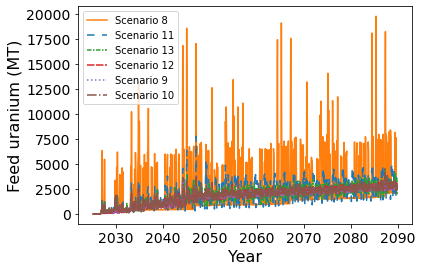

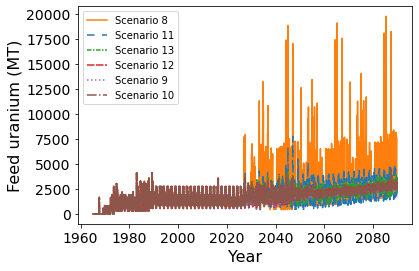

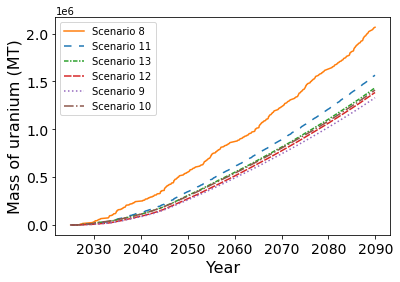

In [160]:
for key in ['s08','s11', 's13','s12','s09','s10']:
    AR_feed = feed_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_feed += feed_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_feed[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_feed.pdf', bbox_inches='tight')
    
    plt.figure(1)
    feed_1percent[key+'_total'] = AR_feed + feed_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], feed_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Feed uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_feed.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(uranium_to_reactors_1percent[key+'_MMR']['Year'][721:], AR_feed[721:].cumsum()/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass of uranium (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_feed_cumulative.pdf', bbox_inches='tight')

In [104]:
#Reporting feed masses
for scenario in plotting_order_1percent:
    HALEU_feed = feed_1percent[scenario+'_MMR']+feed_1percent[scenario+'_Xe-100']
    print('Average HALEU feed in',scenario,'after 2025:', HALEU_feed[721:].mean())
    AR_feed = HALEU_feed + feed_1percent[scenario+'_VOYGR']
    print('Average mass in ', scenario, ':', AR_feed[721:].mean())
    print('Maximum mass in ', scenario, ':', AR_feed[721:].max())

Average HALEU feed in s11 after 2025: 103765.93672404732
Average mass in  s11 : 2008734.3397430952
Maximum mass in  s11 : 7750973.518468176
Average HALEU feed in s08 after 2025: 2653012.675033552
Average mass in  s08 : 2653012.675033552
Maximum mass in  s08 : 19741238.80243594
Average HALEU feed in s13 after 2025: 1508156.6401552581
Average mass in  s13 : 1840403.761758196
Maximum mass in  s13 : 4378549.616268329
Average HALEU feed in s12 after 2025: 1295261.296781604
Average mass in  s12 : 1777287.6071282388
Maximum mass in  s12 : 3625549.4329210003
Average HALEU feed in s09 after 2025: 1706467.3816712128
Average mass in  s09 : 1706467.3816712128
Maximum mass in  s09 : 3546850.44223552
Average HALEU feed in s10 after 2025: 1809521.433311922
Average mass in  s10 : 1809521.433311922
Maximum mass in  s10 : 4499608.398142537


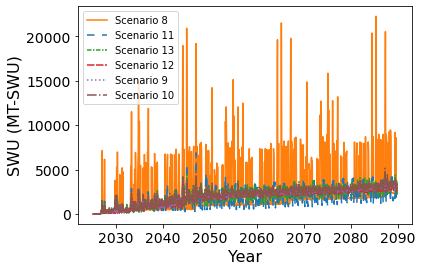

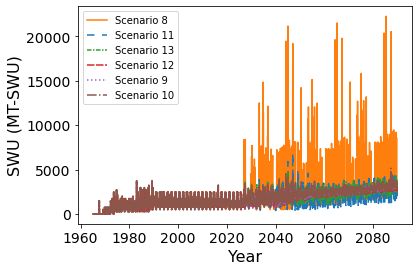

In [161]:
for key in ['s08','s11', 's13','s12','s09','s10']:
    AR_SWU = SWU_1percent[key+'_MMR'].copy()
    for reactor in ['Xe-100','VOYGR']:
        AR_SWU += SWU_1percent[key + '_' + reactor]
    plt.figure(0)
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'][721:], AR_SWU[721:]/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_AR_SWU.pdf', bbox_inches='tight')
    
    plt.figure(1)
    SWU_1percent[key+'_total'] = AR_SWU + SWU_1percent[key +'_LWR']
    plt.plot(uranium_to_reactors_1percent[key + '_MMR']['Year'], SWU_1percent[key+'_total']/1000, 
             label=labels[key], linestyle=lines[key], color=colors[key])
    plt.legend()
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('SWU (MT-SWU)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('figures/1percent_SWU.pdf', bbox_inches='tight')

In [107]:
#Reporting SWU requirements
for scenario in plotting_order_1percent:
    HALEU_SWU = SWU_1percent[scenario+'_MMR'] + SWU_1percent[scenario+'_Xe-100']
    print('Average SWU for HALEU in', scenario, 'after 2025:', HALEU_SWU[721:].mean())
    AR_SWU = HALEU_SWU + SWU_1percent[scenario+'_VOYGR']
    print('Average capacity in ', scenario, ':', AR_SWU[721:].mean())
    print('Maximum capacity in ', scenario, ':', AR_SWU[721:].max())   

Average SWU for HALEU in s11 after 2025: 117048.38725085823
Average capacity in  s11 : 1805924.5514918934
Maximum capacity in  s11 : 6871733.097650476
Average SWU for HALEU in s08 after 2025: 2992608.7960308273
Average capacity in  s08 : 2992608.7960308273
Maximum capacity in  s08 : 22268195.48985672
Average SWU for HALEU in s13 after 2025: 1730349.4480416675
Average capacity in  s13 : 2024907.7427743298
Maximum capacity in  s13 : 4468580.643440394
Average SWU for HALEU in s12 after 2025: 1491223.686131025
Average capacity in  s12 : 1918570.798446013
Maximum capacity in  s12 : 4059158.9214471905
Average SWU for HALEU in s09 after 2025: 1964641.8722470137
Average capacity in  s09 : 1964641.8722470137
Maximum capacity in  s09 : 4083459.7650436237
Average SWU for HALEU in s10 after 2025: 2076133.6779711815
Average capacity in  s10 : 2076133.6779711815
Maximum capacity in  s10 : 5149118.348973167


In [81]:
# Waste discharged from reactors

waste_1percent = {'s08_MMR':'', 's08_Xe-100':'', 's08_VOYGR':'', 's08_LWR':'', 's08_total':'',
                       's09_MMR':'', 's09_Xe-100':'', 's09_VOYGR':'', 's09_LWR':'', 's09_total':'',
                       's10_MMR':'', 's10_Xe-100':'', 's10_VOYGR':'', 's10_LWR':'', 's10_total':'',
                       's11_MMR':'', 's11_Xe-100':'', 's11_VOYGR':'', 's11_LWR':'', 's11_total':'',
                       's12_MMR':'', 's12_Xe-100':'', 's12_VOYGR':'', 's12_LWR':'', 's12_total':'',
                       's13_MMR':'', 's13_Xe-100':'', 's13_VOYGR':'', 's13_LWR':'', 's13_total':'',}

for key in waste_1percent:
    scenario = key[:3]
    reactor = key[4:]
    if reactor != 'total':
        waste_1percent[key] = tm.commodity_mass_traded(transactions_1percent[scenario], waste_commodity[reactor])

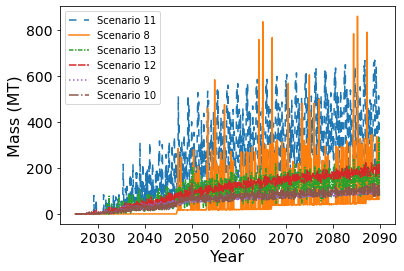

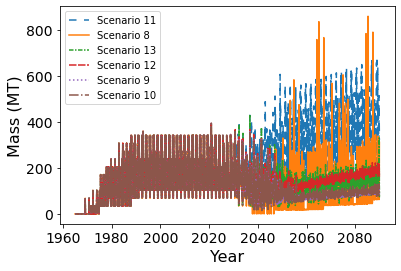

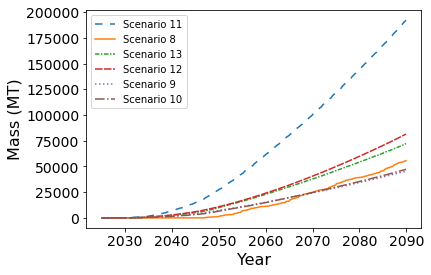

In [163]:
for key in plotting_order_1percent:
    AR_waste = waste_1percent[key + '_MMR'].copy()
    for reactor in ['Xe-100', 'VOYGR']:
        AR_waste['Quantity'] += waste_1percent[key + '_' + reactor]['Quantity']
    plt.figure(0)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:]/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_AR_waste.pdf', bbox_inches='tight')
    
    plt.figure(1)
    waste_1percent[key+'_total'] = AR_waste['Quantity'] + waste_1percent[key + '_LWR']['Quantity']
    plt.plot(AR_waste['Year'], waste_1percent[key+'_total']/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_waste.pdf', bbox_inches='tight')
    
    plt.figure(2)
    plt.plot(AR_waste['Year'][721:], AR_waste['Quantity'][721:].cumsum()/1000, label=labels[key],
            linestyle=lines[key], color=colors[key])
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Mass (MT)', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.savefig('figures/1percent_waste_cumulative.pdf', bbox_inches='tight')

In [109]:
#Reporting waste masses
for scenario in plotting_order_1percent:
    HALEU_waste = waste_1percent[scenario+'_MMR']['Quantity'] + waste_1percent[scenario+'_Xe-100']['Quantity']
    print('Average HALEU waste in',scenario,'after 2025:', HALEU_waste[721:].mean())
    AR_waste = HALEU_waste + waste_1percent[scenario+'_VOYGR']['Quantity']
    print('Average mass in ', scenario, ':', AR_waste[721:].mean())
    print('Maximum mass in ', scenario, ':', AR_waste[721:].max())

Average HALEU waste in s11 after 2025: 3410.115789473684
Average mass in  s11 : 246597.21409499354
Maximum mass in  s11 : 668451.1400000011
Average HALEU waste in s08 after 2025: 71432.2222079588
Average mass in  s08 : 71432.2222079588
Maximum mass in  s08 : 859576.519999997
Average HALEU waste in s13 after 2025: 50456.63838767668
Average mass in  s13 : 92716.5209807447
Maximum mass in  s13 : 330565.53600000055
Average HALEU waste in s12 after 2025: 44502.80699358171
Average mass in  s12 : 104565.06550449313
Maximum mass in  s12 : 222489.37200000018
Average HALEU waste in s09 after 2025: 58352.741191271
Average mass in  s09 : 58352.741191271
Maximum mass in  s09 : 115807.41199999966
Average HALEU waste in s10 after 2025: 60590.444729140094
Average mass in  s10 : 60590.444729140094
Maximum mass in  s10 : 134711.54000000033
